# Different Amplitude

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def spike(t, t0, s, a):
    z = (t - t0) / s
    return a * np.exp(-0.5 * z * z)

def gen(N=2000, L=200, pos=(20, 60, 100, 140, 180),
        seed=0, seed_evt=1,
        s=2.5, amps=(0.10, 0.25, 0.50), p=(0.2, 0.6, 0.2),
        # baseline params
        a_rng=(0.05, 0.1), b_rng=(-0.02, 0.02),
        ks=(5, 8, 11), A_rng=(0.05, 0.1),
        phis=(0.0, np.pi/2, np.pi, 3*np.pi/2),
        noise=0.01):
    """
    Returns:
      X: (N, L, 1)
      comps: dict with X0 (baseline), pos, A (true amps), etc.
    """
    pos = np.asarray(pos, dtype=np.int32)
    if pos.size != 5:
        raise ValueError("pos must have 5 positions")
    if np.any(pos < 0) or np.any(pos >= L):
        raise ValueError("some pos out of range")

    rng = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed_evt)
    t = np.arange(L, dtype=np.float32)

    # ---- baseline X0: (N, L) ----
    X0 = np.zeros((N, L), dtype=np.float32)
    for i in range(N):
        a = rng.uniform(*a_rng)
        b = rng.uniform(*b_rng)
        trend = (b + a * (t / (L - 1))).astype(np.float32)

        season = np.zeros(L, dtype=np.float32)
        for k in ks:
            Ak = rng.uniform(*A_rng)
            phi = float(rng.choice(np.asarray(phis, dtype=np.float32)))
            season += (Ak * np.sin(2*np.pi*k*t/L + phi)).astype(np.float32)

        X0[i] = trend + season + rng.normal(0, noise, size=L).astype(np.float32)

    # ---- extreme amps: (N, 5) ----
    amps = np.asarray(amps, dtype=np.float32)
    p = np.asarray(p, dtype=np.float32)
    p = p / p.sum()
    A = rng2.choice(amps, size=(N, 5), replace=True, p=p).astype(np.float32)

    # ---- final X: (N, L) ----
    X = X0.copy()
    for i in range(N):
        for j, t0 in enumerate(pos):
            X[i] += spike(t, float(t0), float(s), float(A[i, j])).astype(np.float32)

    # reshape to (N, L, 1)
    X  = X[:, :, None].astype(np.float32)
    X0 = X0[:, :, None].astype(np.float32)

    comps = {
        "X0": X0,          # baseline (N,L,1)
        "pos": pos,        # (5,)
        "A": A,            # true amps at 5 positions (N,5)
        "s": float(s),
        "amps": amps.copy(),
        "p": p.copy(),
        "seed": int(seed),
        "seed_evt": int(seed_evt),
    }
    return X, comps

In [2]:
def show5(X, pos=None, seed=0):
    X = np.asarray(X)
    if X.ndim != 3 or X.shape[2] != 1:
        raise ValueError("X must have shape (N, L, 1)")
    N, L, _ = X.shape

    rng = np.random.default_rng(seed)
    idx = rng.choice(np.arange(N), size=5, replace=False)

    t = np.arange(L)
    plt.figure(figsize=(10, 4))
    for i in idx:
        plt.plot(t, X[i, :, 0], alpha=0.9, label=f"i={int(i)}")
    if pos is not None:
        for t0 in np.asarray(pos).astype(int):
            plt.axvline(t0, linestyle="--", linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

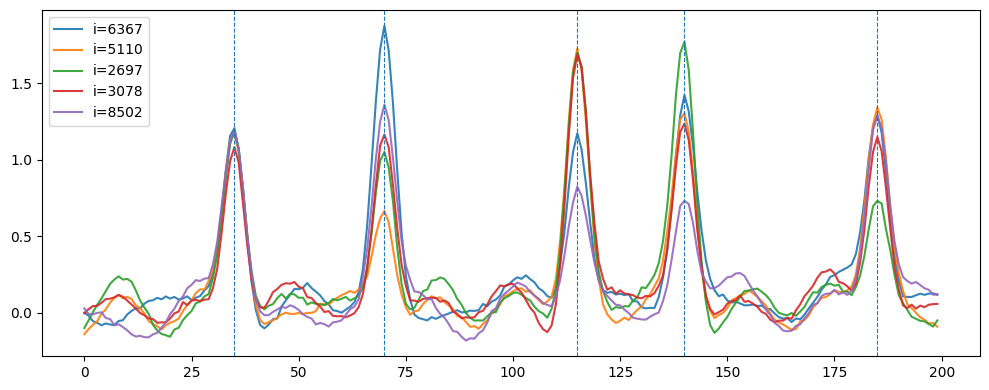

In [3]:
X, comps = gen(N=10000, L=200, pos=(35, 70, 115, 140, 185), amps=(0.75, 1.25, 1.75), p=(0.2, 0.6, 0.2))
show5(X, pos=comps["pos"], seed=0)

{0.75: (9965, 0.1993), 1.25: (30001, 0.60002), 1.75: (10034, 0.20068), 'other': (0, 0.0)}


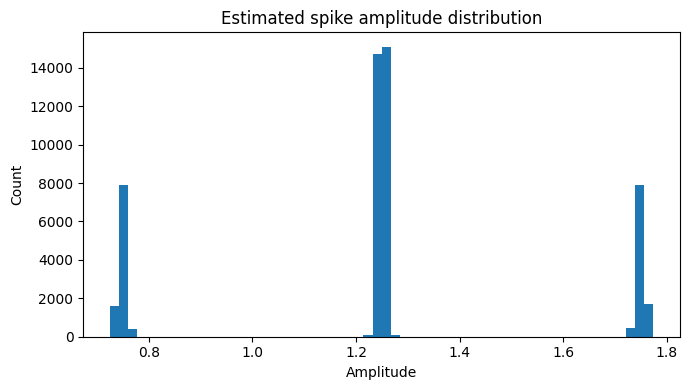

True amp mean/std: 1.25069 0.3162191
Est  amp mean/std: 1.2501947 0.3162894


In [10]:
def build_design_matrix(L, ks=(5, 8, 11)):
    t = np.arange(L, dtype=np.float32)
    tn = (t / (L - 1)).astype(np.float32)

    cols = [np.ones(L, dtype=np.float32), tn]  # intercept + linear trend
    for k in ks:
        ang = 2.0 * np.pi * float(k) * t / float(L)
        cols.append(np.sin(ang).astype(np.float32))
        cols.append(np.cos(ang).astype(np.float32))
    D = np.stack(cols, axis=1)  # (L, P)
    return D

def make_mask(L, pos, w):
    pos = np.asarray(pos, dtype=np.int32)
    m = np.ones(L, dtype=bool)
    for t0 in pos:
        a = max(0, int(t0) - int(w))
        b = min(L, int(t0) + int(w) + 1)
        m[a:b] = False
    return m

def fit_baseline_ls(X, pos, ks=(5,8,11), sigma=2.5, ridge=0.0):
    """
    X: (N,L,1)
    pos: event centers (M,)
    sigma: spike width prior, used only to set mask width w=ceil(3*sigma)
    ridge: optional L2 regularization for stability (0.0 means plain LS)
    return:
      Bhat: (N,L) baseline estimate
    """
    X = np.asarray(X, dtype=np.float32)
    N, L, C = X.shape
    assert C == 1

    w = int(np.ceil(3.0 * float(sigma)))
    D = build_design_matrix(L, ks=ks)          # (L,P)
    m = make_mask(L, pos, w=w)                # (L,)
    Dm = D[m]                                 # (Lm,P)

    # Precompute normal equation pieces for ridge
    # beta = argmin ||Dm beta - ym||^2 + ridge||beta||^2
    # (Dm^T Dm + ridge I) beta = Dm^T ym
    P = D.shape[1]
    AtA = (Dm.T @ Dm).astype(np.float32)
    if ridge > 0:
        AtA = AtA + (float(ridge) * np.eye(P, dtype=np.float32))
    AtA_inv = np.linalg.inv(AtA)  # P x P
    At = Dm.T.astype(np.float32)  # P x Lm

    Bhat = np.zeros((N, L), dtype=np.float32)
    for i in range(N):
        y = X[i, :, 0]
        ym = y[m].astype(np.float32)          # (Lm,)
        beta = AtA_inv @ (At @ ym)            # (P,)
        Bhat[i] = (D @ beta).astype(np.float32)
    return Bhat

# -----------------------------
# (2) Spike amplitude estimation using Gaussian template prior
# -----------------------------
def gaussian_template(L, t0, sigma):
    t = np.arange(L, dtype=np.float32)
    z = (t - float(t0)) / float(sigma)
    g = np.exp(-0.5 * z * z).astype(np.float32)
    return g

def estimate_spike_amplitudes(X, pos, ks=(5,8,11), sigma=2.5, ridge=0.0):
    """
    Steps:
      1) Fit baseline with masking
      2) residual R = X - baseline
      3) For each event center t0, estimate amplitude by matched filter (LS):
           Ahat = (g^T r)/(g^T g), computed on window [t0-w, t0+w]
    return:
      Ahat: (N,M) estimated amplitudes
      Bhat: (N,L) baseline
      R:    (N,L) residual
    """
    X = np.asarray(X, dtype=np.float32)
    N, L, _ = X.shape
    pos = np.asarray(pos, dtype=np.int32)
    M = pos.size

    w = int(np.ceil(3.0 * float(sigma)))
    Bhat = fit_baseline_ls(X, pos, ks=ks, sigma=sigma, ridge=ridge)  # (N,L)
    R = X[:, :, 0] - Bhat                                            # (N,L)

    Ahat = np.zeros((N, M), dtype=np.float32)
    for j, t0 in enumerate(pos):
        a = max(0, int(t0) - w)
        b = min(L, int(t0) + w + 1)

        g_full = gaussian_template(L, t0, sigma)  # (L,)
        g = g_full[a:b]                           # (W,)
        denom = float(np.sum(g * g) + 1e-12)

        # Ahat_i = (g^T r_i)/(g^T g)
        num = (R[:, a:b] * g[None, :]).sum(axis=1)  # (N,)
        Ahat[:, j] = (num / denom).astype(np.float32)

    return Ahat, Bhat, R

# -----------------------------
# (3) Summarize and plot amplitude distribution
# -----------------------------
def summarize_amp_distribution(Ahat, bins=60, title="Estimated spike amplitude distribution"):
    Af = Ahat.reshape(-1)
    plt.figure(figsize=(7,4))
    plt.hist(Af, bins=bins)
    plt.title(title)
    plt.xlabel("Amplitude")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    return stats



def amp_ratio_3(Ahat, amps=(0.75, 1.25, 1.75), tol=0.08):
    """
    Ahat: (N, M) 估计的幅度，或任何一维/二维数组都行
    amps: 目标三档幅度
    tol: 允许“附近”的半径，例如 0.08 表示落在 [a-tol, a+tol] 视为该档

    return: dict
      {0.75:(count, ratio), 1.25:(count, ratio), 1.75:(count, ratio), "other":(...)}
    """
    x = np.asarray(Ahat, dtype=np.float32).reshape(-1)  # flatten
    amps = np.asarray(amps, dtype=np.float32)

    # 每个样本找到最近的档位
    d = np.abs(x[:, None] - amps[None, :])          # (S,3)
    idx = np.argmin(d, axis=1)                      # (S,)
    best = d[np.arange(x.size), idx]                # (S,)

    # 在 tol 内才算命中该档，否则 other
    lab = np.full(x.size, -1, dtype=np.int32)
    hit = best <= float(tol)
    lab[hit] = idx[hit]

    out = {}
    total = int(x.size)
    for k, a in enumerate(amps):
        c = int(np.sum(lab == k))
        out[float(a)] = (c, c / total if total > 0 else 0.0)

    other = int(np.sum(lab < 0))
    out["other"] = (other, other / total if total > 0 else 0.0)
    return out



pos = comps["pos"]
Ahat, Bhat, R = estimate_spike_amplitudes(X, pos, ks=(5,8,11), sigma=comps["s"], ridge=1e-6)
ratios = amp_ratio_3(Ahat, amps=(0.75, 1.25, 1.75), tol=0.10)
print(ratios)
summarize_amp_distribution(Ahat, bins=60)

trueA = comps["A"].reshape(-1)
estA  = Ahat.reshape(-1)
print("True amp mean/std:", trueA.mean(), trueA.std())
print("Est  amp mean/std:", estA.mean(), estA.std())


In [21]:
X1 = X.reshape(-1,1)
np.save(f"top_example_seq_{L}_sample_{N}.npy", X1)

## Different Location

In [16]:
import numpy as np

def spike(t, t0, s, a):
    z = (t - t0) / s
    return a * np.exp(-0.5 * z * z)

def gen_posmix(
    N=2000, L=200,
    pos3=(35, 115, 185),          # 只用 3 个位置
    p_pos=(0.2, 0.6, 0.2),        # 三个位置占比
    amp=1.5,                      # 幅度统一
    seed=0, seed_evt=1,
    s=2.5,
    # baseline params (保持不变)
    a_rng=(0.05, 0.1), b_rng=(-0.02, 0.02),
    ks=(5, 8, 11), A_rng=(0.05, 0.1),
    phis=(0.0, np.pi/2, np.pi, 3*np.pi/2),
    noise=0.01
):
    """
    Returns:
      X: (N, L, 1)
      comps: dict with X0 (baseline), pos3, loc_idx, A (true amps per pos3), etc.
    """
    pos3 = np.asarray(pos3, dtype=np.int32)
    if pos3.size != 3:
        raise ValueError("pos3 must have 3 positions")
    if np.any(pos3 < 0) or np.any(pos3 >= L):
        raise ValueError("some pos3 out of range")

    p_pos = np.asarray(p_pos, dtype=np.float32)
    p_pos = p_pos / p_pos.sum()

    rng = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed_evt)
    t = np.arange(L, dtype=np.float32)

    # ---- baseline X0: (N, L) ----
    X0 = np.zeros((N, L), dtype=np.float32)
    for i in range(N):
        a = rng.uniform(*a_rng)
        b = rng.uniform(*b_rng)
        trend = (b + a * (t / (L - 1))).astype(np.float32)

        season = np.zeros(L, dtype=np.float32)
        for k in ks:
            Ak = rng.uniform(*A_rng)
            phi = float(rng.choice(np.asarray(phis, dtype=np.float32)))
            season += (Ak * np.sin(2*np.pi*k*t/L + phi)).astype(np.float32)

        X0[i] = trend + season + rng.normal(0, noise, size=L).astype(np.float32)

    # ---- sample ONE event location per sequence (N,) ----
    loc_idx = rng2.choice(3, size=N, replace=True, p=p_pos).astype(np.int32)  # 0/1/2

    # ---- true amps matrix A: (N, 3) (one-hot amp) ----
    A = np.zeros((N, 3), dtype=np.float32)
    A[np.arange(N), loc_idx] = float(amp)

    # ---- final X: (N, L) ----
    X = X0.copy()
    for i in range(N):
        j = int(loc_idx[i])
        t0 = int(pos3[j])
        X[i] += spike(t, float(t0), float(s), float(amp)).astype(np.float32)

    # reshape to (N, L, 1)
    X  = X[:, :, None].astype(np.float32)
    X0 = X0[:, :, None].astype(np.float32)

    comps = {
        "X0": X0,             # baseline (N,L,1)
        "pos3": pos3,         # (3,)
        "loc_idx": loc_idx,   # (N,) 每条序列极值位置类别 0/1/2
        "A": A,               # (N,3) true amps per pos3
        "amp": float(amp),
        "p_pos": p_pos.copy(),
        "s": float(s),
        "seed": int(seed),
        "seed_evt": int(seed_evt),
    }
    return X, comps

In [17]:
def show5(X, pos=None, seed=0):
    X = np.asarray(X)
    if X.ndim != 3 or X.shape[2] != 1:
        raise ValueError("X must have shape (N, L, 1)")
    N, L, _ = X.shape

    rng = np.random.default_rng(seed)
    idx = rng.choice(np.arange(N), size=5, replace=False)

    t = np.arange(L)
    plt.figure(figsize=(10, 4))
    for i in idx:
        plt.plot(t, X[i, :, 0], alpha=0.9, label=f"i={int(i)}")
    if pos is not None:
        for t0 in np.asarray(pos).astype(int):
            plt.axvline(t0, linestyle="--", linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

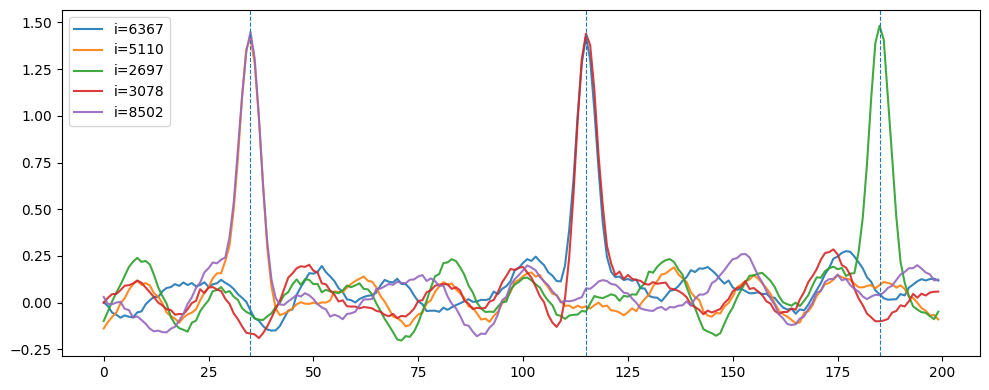

In [19]:
X, comps = gen_posmix(N=10000, L=200, pos3=(35, 115, 185), p_pos=(0.2, 0.6, 0.2), amp=1.5)
show5(X, pos=(35, 115, 185), seed=0)

In [20]:
counts = np.bincount(comps["loc_idx"], minlength=3)
print("counts:", counts)
print("ratios:", counts / counts.sum())

counts: [1999 5979 2022]
ratios: [0.1999 0.5979 0.2022]


In [22]:
X1 = X.reshape(-1,1)
np.save(f"top_example_seq_{L}_sample_{N}.npy", X1)

### Different Shape 

In [25]:
import numpy as np

# -----------------------------
# Shape templates (peak at t0 is 1, then scaled by amp)
# -----------------------------
def _gaussian(t, t0, sigma):
    z = (t - t0) / sigma
    return np.exp(-0.5 * z * z).astype(np.float32)

def _asym_gaussian(t, t0, sigma_left, sigma_right):
    out = np.empty_like(t, dtype=np.float32)
    left = t <= t0
    zL = (t[left] - t0) / sigma_left
    zR = (t[~left] - t0) / sigma_right
    out[left]  = np.exp(-0.5 * zL * zL).astype(np.float32)
    out[~left] = np.exp(-0.5 * zR * zR).astype(np.float32)
    return out

def _gabor(t, t0, sigma, f0=0.22):
    env = _gaussian(t, t0, sigma)
    phase = 2.0 * np.pi * float(f0) * (t - t0)
    return (env * np.cos(phase)).astype(np.float32)  # can have negative lobes

def _shape_template(t, t0, shape_id, s_base, shape_params):
    if shape_id == 0:
        return _gaussian(t, t0, sigma=s_base)
    elif shape_id == 1:
        sl = float(shape_params.get("sigma_left",  1.6))
        sr = float(shape_params.get("sigma_right", 3.8))
        return _asym_gaussian(t, t0, sigma_left=sl, sigma_right=sr)
    elif shape_id == 2:
        f0 = float(shape_params.get("f0", 0.22))
        return _gabor(t, t0, sigma=s_base, f0=f0)
    else:
        raise ValueError("shape_id must be 0,1,2")

# -----------------------------
# Generator: fixed position t0=100, one event per sample, shape mixture
# -----------------------------
def gen_shape_mix_fixed_center(
    N=2000, L=200,
    t0=100,                              # fixed event center
    p_shape=(0.2, 0.6, 0.2),             # Gaussian / Asym / Gabor
    amp=1.5,
    seed=0, seed_evt=1,
    s_base=2.5,
    shape_params=None,
    # baseline params (same as your original)
    a_rng=(0.05, 0.1), b_rng=(-0.02, 0.02),
    ks=(5, 8, 11), A_rng=(0.05, 0.1),
    phis=(0.0, np.pi/2, np.pi, 3*np.pi/2),
    noise=0.01
):
    """
    One event per sample at fixed t0.
    Returns:
      X: (N,L,1)
      comps: includes X0, t0, shape_idx, etc.
    """
    if t0 < 0 or t0 >= L:
        raise ValueError("t0 out of range")

    p_shape = np.asarray(p_shape, dtype=np.float32)
    p_shape = p_shape / p_shape.sum()

    if shape_params is None:
        shape_params = {}

    rng = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed_evt)
    t = np.arange(L, dtype=np.float32)

    # ---- baseline X0 ----
    X0 = np.zeros((N, L), dtype=np.float32)
    for i in range(N):
        a = rng.uniform(*a_rng)
        b = rng.uniform(*b_rng)
        trend = (b + a * (t / (L - 1))).astype(np.float32)

        season = np.zeros(L, dtype=np.float32)
        for k in ks:
            Ak = rng.uniform(*A_rng)
            phi = float(rng.choice(np.asarray(phis, dtype=np.float32)))
            season += (Ak * np.sin(2*np.pi*float(k)*t/float(L) + phi)).astype(np.float32)

        X0[i] = trend + season + rng.normal(0, noise, size=L).astype(np.float32)

    # ---- sample shape per sample ----
    shape_idx = rng2.choice(3, size=N, replace=True, p=p_shape).astype(np.int32)

    # ---- add event at fixed center ----
    X = X0.copy()
    for i in range(N):
        sid = int(shape_idx[i])
        tpl = _shape_template(t, float(t0), sid, s_base=float(s_base), shape_params=shape_params)  # peak=1
        X[i] += (float(amp) * tpl).astype(np.float32)

    X  = X[:, :, None].astype(np.float32)
    X0 = X0[:, :, None].astype(np.float32)

    comps = {
        "X0": X0,
        "t0": int(t0),
        "shape_idx": shape_idx,          # (N,) 0/1/2
        "amp": float(amp),
        "p_shape": p_shape.copy(),
        "s_base": float(s_base),
        "shape_params": dict(shape_params),
        "seed": int(seed),
        "seed_evt": int(seed_evt),
        "shape_names": {0: "gaussian", 1: "asymmetric_gaussian", 2: "gabor_burst"},
    }
    return X, comps

In [26]:
X, comps = gen_shape_mix_fixed_center(
    N=10000, L=200, t0=100,
    p_shape=(0.2, 0.6, 0.2),
    amp=1.5, s_base=2.5,
    shape_params={"sigma_left": 1.6, "sigma_right": 3.8, "f0": 0.22}
)

In [27]:
def show5(X, pos=None, seed=0):
    X = np.asarray(X)
    if X.ndim != 3 or X.shape[2] != 1:
        raise ValueError("X must have shape (N, L, 1)")
    N, L, _ = X.shape

    rng = np.random.default_rng(seed)
    idx = rng.choice(np.arange(N), size=5, replace=False)

    t = np.arange(L)
    plt.figure(figsize=(10, 4))
    for i in idx:
        plt.plot(t, X[i, :, 0], alpha=0.9, label=f"i={int(i)}")
    if pos is not None:
        for t0 in np.asarray(pos).astype(int):
            plt.axvline(t0, linestyle="--", linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

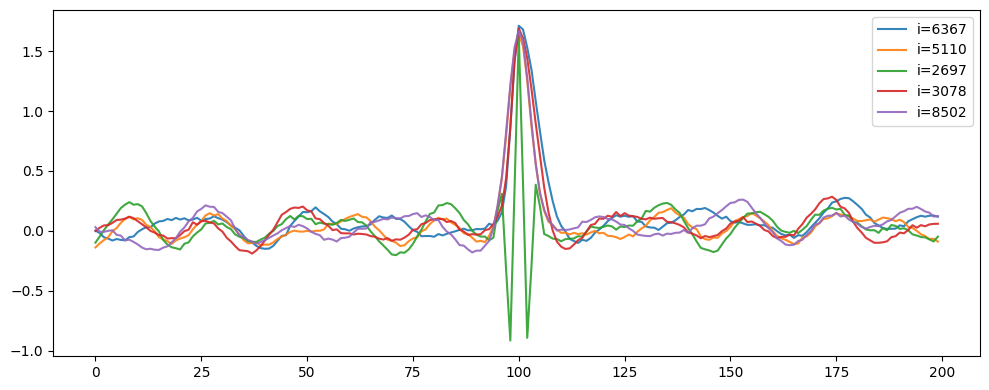

In [28]:
show5(X)

In [29]:
import numpy as np

# -----------------------------
# templates (peak at t0 is 1)
# -----------------------------
def _gaussian(t, t0, sigma):
    z = (t - t0) / sigma
    return np.exp(-0.5 * z * z).astype(np.float32)

def _asym_gaussian(t, t0, sigma_left, sigma_right):
    out = np.empty_like(t, dtype=np.float32)
    left = t <= t0
    zL = (t[left] - t0) / sigma_left
    zR = (t[~left] - t0) / sigma_right
    out[left]  = np.exp(-0.5 * zL * zL).astype(np.float32)
    out[~left] = np.exp(-0.5 * zR * zR).astype(np.float32)
    return out

def _gabor(t, t0, sigma, f0=0.22):
    env = _gaussian(t, t0, sigma)
    phase = 2.0 * np.pi * float(f0) * (t - t0)
    return (env * np.cos(phase)).astype(np.float32)

def _shape_template(t, t0, shape_id, s_base, shape_params):
    if shape_id == 0:
        return _gaussian(t, t0, sigma=float(s_base))
    elif shape_id == 1:
        sl = float(shape_params.get("sigma_left",  1.6))
        sr = float(shape_params.get("sigma_right", 3.8))
        return _asym_gaussian(t, t0, sigma_left=sl, sigma_right=sr)
    elif shape_id == 2:
        f0 = float(shape_params.get("f0", 0.22))
        return _gabor(t, t0, sigma=float(s_base), f0=f0)
    else:
        raise ValueError("shape_id must be 0,1,2")

# -----------------------------
# baseline fitting: intercept + linear trend + Fourier(ks), masked around t0
# -----------------------------
def _build_design_matrix(L, ks=(5, 8, 11)):
    t = np.arange(L, dtype=np.float32)
    tn = (t / (L - 1)).astype(np.float32)
    cols = [np.ones(L, dtype=np.float32), tn]
    for k in ks:
        ang = 2.0 * np.pi * float(k) * t / float(L)
        cols.append(np.sin(ang).astype(np.float32))
        cols.append(np.cos(ang).astype(np.float32))
    return np.stack(cols, axis=1)  # (L,P)

def _mask_center(L, t0, w):
    m = np.ones(L, dtype=bool)
    a = max(0, int(t0) - int(w))
    b = min(L, int(t0) + int(w) + 1)
    m[a:b] = False
    return m

def _fit_baseline_one(y, D, mask, ridge=0.0):
    """
    y: (L,)
    D: (L,P)
    mask: (L,)
    """
    Dm = D[mask]          # (Lm,P)
    ym = y[mask]          # (Lm,)
    P = D.shape[1]

    if ridge > 0:
        AtA = Dm.T @ Dm + float(ridge) * np.eye(P, dtype=np.float32)
        Aty = Dm.T @ ym
        beta = np.linalg.solve(AtA.astype(np.float32), Aty.astype(np.float32))
    else:
        beta, *_ = np.linalg.lstsq(Dm, ym, rcond=None)
        beta = beta.astype(np.float32)

    return (D @ beta).astype(np.float32)  # (L,)

# -----------------------------
# main detector: template matching with amplitude LS, choose min SSE
# -----------------------------
def detect_shape_types(
    X, t0=100,
    ks=(5, 8, 11),
    s_base=2.5,
    shape_params=None,
    win=None,
    ridge=0.0,
    return_scores=False
):
    """
    Detect 3 extreme shape types by baseline removal + template matching.

    Inputs
    - X: (N,L,1)
    - t0: fixed event center
    - ks: baseline seasonality frequencies
    - s_base: base width used by gaussian & gabor
    - shape_params: dict, e.g. {"sigma_left":1.6, "sigma_right":3.8, "f0":0.22}
    - win: half-window size around t0 for matching. If None, win = ceil(3*s_base)
    - ridge: optional baseline ridge for stability
    - return_scores: if True, also return per-shape SSE and Ahat

    Returns
    - pred: (N,) int in {0,1,2}
    - (optional) info: dict with sse (N,3), ahat (N,3)
    """
    X = np.asarray(X, dtype=np.float32)
    N, L, C = X.shape
    assert C == 1

    if shape_params is None:
        shape_params = {}

    if win is None:
        win = int(np.ceil(3.0 * float(s_base)))
    win = int(win)

    if not (0 <= int(t0) < L):
        raise ValueError("t0 out of range")

    # baseline prep
    D = _build_design_matrix(L, ks=ks)                 # (L,P)
    mask = _mask_center(L, t0=int(t0), w=win)          # (L,)

    # window indices
    a = max(0, int(t0) - win)
    b = min(L, int(t0) + win + 1)
    t = np.arange(L, dtype=np.float32)
    idx = np.arange(a, b, dtype=np.int32)

    # precompute templates on the window
    G = []
    for sid in (0, 1, 2):
        g_full = _shape_template(t, float(t0), sid, s_base=float(s_base), shape_params=shape_params)
        g = g_full[a:b].astype(np.float32)
        G.append(g)
    G = np.stack(G, axis=0)  # (3, W)
    denom = (G * G).sum(axis=1) + 1e-12  # (3,)

    pred = np.zeros(N, dtype=np.int32)
    sse_all = np.zeros((N, 3), dtype=np.float32)
    ahat_all = np.zeros((N, 3), dtype=np.float32)

    for i in range(N):
        y = X[i, :, 0]  # (L,)
        B = _fit_baseline_one(y, D, mask, ridge=ridge)  # (L,)
        r = (y - B).astype(np.float32)                  # residual (L,)
        rw = r[a:b]                                     # (W,)

        # for each shape: Ahat = (g^T r)/(g^T g), sse = ||r - Ahat g||^2
        # vectorized over 3 shapes
        num = (G * rw[None, :]).sum(axis=1)            # (3,)
        ahat = num / denom                             # (3,)
        recon = ahat[:, None] * G                      # (3,W)
        err = rw[None, :] - recon
        sse = (err * err).sum(axis=1)                  # (3,)

        ahat_all[i] = ahat.astype(np.float32)
        sse_all[i] = sse.astype(np.float32)
        pred[i] = int(np.argmin(sse))

    if return_scores:
        info = {
            "sse": sse_all,      # (N,3) smaller is better
            "ahat": ahat_all,    # (N,3) fitted amplitude per template
            "win_idx": idx,      # window indices used
            "shape_names": {0: "gaussian", 1: "asymmetric_gaussian", 2: "gabor_burst"},
        }
        return pred, info
    return pred


In [30]:
pred, info = detect_shape_types(
    X, t0=100,
    ks=(5,8,11),
    s_base=2.5,
    shape_params={"sigma_left": 1.6, "sigma_right": 3.8, "f0": 0.22},
    ridge=1e-6,
    return_scores=True
)

# 统计预测比例
counts = np.bincount(pred, minlength=3)
print("pred counts:", counts)
print("pred ratios:", counts / counts.sum())

# 如果你有真值 comps["shape_idx"]，看一下准确率
acc = (pred == comps["shape_idx"]).mean()
print("acc:", acc)

pred counts: [1999 5979 2022]
pred ratios: [0.1999 0.5979 0.2022]
acc: 1.0


In [31]:
X1 = X.reshape(-1,1)
np.save(f"top_example_seq_{L}_sample_{N}.npy", X1)